# DSE 200 FINAL PROJECT
## Fall 2025
### Due Date: November 21th, 2025

This project is culmination of all you’ve learned in this course! You should expect to spend <b>24-32 total hours</b> on the project. Be sure to read all of the items below before starting.

There are a number of steps outlined below, but is critical that you do not view this as an entirely linear process.  Remember that the science component in data science is the creation of a hypothesis based on exploration and testing of that hypothesis through analysis.  You may need to go through many of these steps multiple times before you arrive at meaningful hypothesis or conclusions.

## Step 1: Find a dataset or datasets

Based on your interest, identify a dataset which you will want to examine.  You will find a starting point for where you can find open datasets at the end of this notebook, but feel free to use other datasets you have access to and can publicly share results about.


This step may take some time, as you’ll likely look at a number of datasets before you find one (or more) which holds promising data for the kinds of questions you want to ask. You are expected to use at least two interconnected datasets, e.g., two tables in one database or a combination of datasets which you can merge in some meaningful way.


In [600]:
#EXPLAIN AND INGEST YOUR DATASET IN THIS SECTION

Let's import what we'll need

In [601]:
!pip install backtesting

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import backtesting

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Donwload what we need from kaggle

In [2]:

# Download latest version
path = kagglehub.dataset_download("mattiuzc/stock-exchange-data")

path2 = kagglehub.dataset_download("saketk511/world-important-events-ancient-to-modern")

print("Path to dataset files:", path)

#with open(path)

Path to dataset files: C:\Users\jlu2\.cache\kagglehub\datasets\mattiuzc\stock-exchange-data\versions\2


Load the Data info dataframes

In [3]:
df_data = pd.read_csv(os.path.join(path, "indexData.csv"))
df_info = pd.read_csv(os.path.join(path, "indexInfo.csv"))
df_processed = pd.read_csv(os.path.join(path, "indexProcessed.csv"))
# df_events = pd.read_csv(os.path.join(path2, "World Important Dates.csv"))

df_events = pd.read_csv(
    os.path.join(path2, "World Important Dates.csv"),
    engine="python",
    quotechar='"',
    skipinitialspace=True
)
# df_events = pd.read_csv(
#     os.path.join(path2, "World Important Dates.csv"),
#     engine="python",
#     quotechar='"',
#     skipinitialspace=True,
#     on_bad_lines="skip"    # or "warn"
# )


## Step 2: Explore the datasets

In this step, you should explore what is present in the data and how the data is organized. You’ll need to determine what common features allow you to merge the datasets.  

You are expected to answer the following questions using the _pandas_ library and markdown cells to describe your actions:

* Are there quality issues in the dataset (noisy, missing data, etc.)?
* What will you need to do to clean and/or transform the raw data for analysis?

You are also expected to use the _matplotlib_ library to visually explore the datasets and explain your findings, specifically,

* How are the data distributed?
* What are some common trends?
* What are the relationships between variables in your datasets?

In [607]:
#PERFORM AND EXPLAIN YOUR EXPLORATORY ANALYSIS IN THIS SECTION

### Data overview
indexData.csv: daily price + volume data for major global indices

indexInfo.csv: metadata: region, exchange, currency, index name

indexProcessed.csv: cleaned version of the price data with USD-normalized closes (CloseUSD)

### Explaination of data analysis
- Looking for data shape, content, & quality issues

From the review we can see that while df_data has the only missing values which also are only numeric columns, the df_processed has been cleaned of all the missing data issues.
Next we'll check the size of the dataframe before the merge and then after to make sure we don't have any loss.

Join the df_data with df_info

# Clean up the df_events and df_data Dataframes before joining on year

In [4]:
df_data['Date'] = pd.to_datetime(df_data['Date'])

In [5]:
df_data['Year'] = df_data['Date'].dt.year
df_data['Month'] = df_data['Date'].dt.month
df_data['Day'] = df_data['Date'].dt.day

In [6]:
# Adding in more features

# Prediction value = Profit
# df_data['p_gain'] = (df_data['Open'] - df_data['Close']) / df_data['Close'] * 100
df_data['Daily_Return'] = df_data.groupby('Index')['Adj Close'].pct_change()
df_data['day_change'] = df_data.groupby('Index')['Adj Close'].diff()
df_data['up'] = df_data.day_change.apply(lambda x: x if x >0 else 0)
df_data['down'] = np.abs(df_data.day_change.apply(lambda x: x if x <0 else 0))
df_data['median'] = (df_data['High'] - df_data['Low']) /2

# Volatility_5D = std of last 5 daily returns
df_data['Volatility_5D'] = (df_data['Daily_Return'].rolling(window=5).std().reset_index(level=0, drop=True))

# Volatility_10D
df_data['Volatility_10D'] = (df_data['Daily_Return'].rolling(window=10).std().reset_index(level=0, drop=True))
    
# Combined the Rolling_Avg_Adj Close_50D with Trend Distance (how far above / below trend is the market
df_data['SMA_50'] = (df_data['Adj Close'].rolling(window=50).mean().reset_index(level=0, drop=True))
df_data['Dist_from_SMA50'] = df_data['Adj Close'] / df_data['SMA_50'] - 1

# Combined the Rolling_Avg_Adj Close_200D with Trend Distance (how far above / below trend is the market
df_data['SMA_200'] = (df_data['Adj Close'].rolling(window=200).mean().reset_index(level=0, drop=True))
df_data['Dist_from_SMA200'] = df_data['Adj Close'] / df_data['SMA_200'] - 1

# Volume_Change (pct change) in market activity
df_data['Volume_Change'] = (df_data['Volume'].pct_change())

# Range = High − Low (shows a raw measure how volatile the day was)
df_data['Range'] =  df_data['High'] - df_data['Low']

# Intraday_Volatility = (High − Low) / Open (shows a standardized measure how volatile the day was by opening price in a single day)
df_data['Intraday_Volatility'] =  (df_data['High'] - df_data['Low']) / (df_data['Open'])

# RS and RSI
df_data['RS'] = (df_data['up'].rolling(window=14).mean().reset_index(level=0, drop=True)) /\
                (df_data['down'].rolling(window=14).mean().reset_index(level=0, drop=True))

df_data['RSI'] = 100 - (100/(1 + df_data['RS']))
# Momentum Oscilator 

df_data['momentum'] = (df_data['median'].rolling(window=5).mean().reset_index(level=0, drop=True)) -\
                      (df_data['median'].rolling(window=34).mean().reset_index(level=0, drop=True))



C:\Users\jlu2\AppData\Local\Temp\ipykernel_12404\3525247349.py:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_data['Daily_Return'] = df_data.groupby('Index')['Adj Close'].pct_change()
C:\Users\jlu2\AppData\Local\Temp\ipykernel_12404\3525247349.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_data['Volume_Change'] = (df_data['Volume'].pct_change())


In [7]:
#get rid of BC years in events 
df_events = df_events.loc[~df_events.Year.astype(str).str.contains('BC')]
df_events['Year'] = df_events['Year'].astype(int)

In [8]:
#sort events by more general category....imported level of detail is a bit much 
df_events['category'] = ''
df_events['Type of Event'] = df_events['Type of Event'].str.lower()
df_events.loc[df_events['Type of Event'].str.contains('partition|violent|conquest|foundational|dictator|referendum|war dec|unification|adminis|nationalization|coup|annex|terror|insurgen|revolt|policy|peace|leglis|constitut|political movement|admin|disobedi|diplo|politic|treaty|rights|refer|corrupt|agree|protest|'), 'category'] = 'violent political'
df_events.loc[df_events['Type of Event'].str.contains('ceasefire|independ|military|war|battle|engagement|conflict|test'), 'category'] = 'military'
df_events.loc[df_events['Type of Event'].str.contains('massacre|execution|incident|disaster|accident|pandemic|genocide|pogrom'), 'category'] = 'disaster'
df_events.loc[df_events['Type of Event'].str.contains('scien|education|agricul|conserva|achiev|rescue|integration|implement|effort|change|discovery|natural|artistic|reform|medical|humanitar|develop|marvel|engineer|tech'), 'category'] = 'achievement'
df_events.loc[df_events['Type of Event'].str.contains('sporting|trade|economi|social|international|cultur|decline|health'), 'category'] = 'socioeconomic'
df_events.loc[df_events['Type of Event'].str.contains('religio'), 'category'] = 'religious'
df_events.loc[((df_events.category.str.contains('polit')) & (df_events.Outcome == 'Positive')), 'category'] = 'peaceful political'

# #encode "outcome to -1 if negative, 0 if mixed, 1 if positive"
df_events['eOutcome'] = 0
df_events.loc[df_events['Outcome'].str.contains('Neg'), 'eOutcome'] = -1
df_events.loc[df_events['Outcome'].str.contains('Mixed|Ongoing'), 'eOutcome'] = 0
df_events.loc[df_events['Outcome'].str.contains('Pos'), 'eOutcome'] = 1


In [9]:
#m...modestly even distribution of events between political/war. Not so much the other stuff thoug h
df_events.groupby('category').count()

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome,eOutcome
category,,,,,,,,,,,,,
achievement,93,93,93,93,93,93,93,93,93,93,93,93,93
disaster,30,30,30,30,30,30,30,30,30,30,30,30,30
military,238,238,232,238,238,238,238,238,238,238,238,238,238
peaceful political,288,288,286,288,288,288,288,288,288,288,288,288,288
religious,21,21,21,21,21,21,21,21,21,21,21,21,21
socioeconomic,204,204,194,204,204,204,204,204,204,204,204,204,204
violent political,215,215,207,215,215,215,215,215,215,215,215,215,215


In [105]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

#group by index and year, get rid of unecessary columns, agg mean, median, and stdev, flatten indices. 
def aggregator(df, groupby = ['Index','Year'], aggs = ['min','max','mean','median','std', 'sum']):
    df2 = df.groupby(groupby).agg(aggs)
    df2.columns = ['_'.join(col).strip() for col in df2.columns.values]
    df2.columns = df2.columns.to_flat_index()
    df2.reset_index(inplace=True)
    if 'Index' in groupby:
        df2['year_index'] = df2['Year'].astype(str) + '_' + df2['Index']
    print(df2.shape)
    return df2

def start_end_dfs(df, month=1, year = False):
    if year:
        startdf = aggregator(df.loc[(df_data.Date.dt.month==1)], aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        enddf = aggregator(df.loc[(df_data.Date.dt.month==12)], aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        return startdf, enddf       
    else:
        startdf = aggregator(df.loc[(df.Date.dt.month==month) & (df.Date.dt.day.isin([1,2,3,4,5,6,7]))], \
                         aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        enddf = aggregator(df.loc[(df.Date.dt.month==month) & (df.Date.dt.day.isin([25,26,27,28,29,30,31]))], \
                       aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        return startdf, enddf

def gains(df, month=0, year=False):
    if month !=0:
        start_df, end_df = start_end_dfs(df, month)
        gain_df = end_df.merge(start_df, how='left', left_on=['year_index'], right_on='year_index', suffixes=['_end', '_start'])
        gain_df['month_pgain'] = (gain_df['Adj Close_mean_end'] - gain_df['Adj Close_mean_start']) / gain_df['Adj Close_mean_start'] * 100
        gain_df['buylowsellhigh_pgain'] = (gain_df['Close_percentile_90_end'] - gain_df['Adj Close_percentile_10_start']) / gain_df['Adj Close_percentile_10_start'] * 100
        gain_df = gain_df.loc[~gain_df['month_pgain'].isna()] #drop these years because they're the start of the dataset
        return gain_df
        
    if year: 
        start_df, end_df = start_end_dfs(df, year = True)
        gain_df = end_df.merge(start_df, how='left', left_on=['year_index'], right_on='year_index', suffixes=['_end', '_start'])
        gain_df['year_pgain'] = (gain_df['Adj Close_mean_end'] - gain_df['Adj Close_mean_start']) / gain_df['Adj Close_mean_start'] * 100
        gain_df['year_sum_pgain'] = (gain_df['Adj Close_mean_end'] - gain_df['Adj Close_mean_start']) / gain_df['Adj Close_mean_start'] * 100
        gain_df = gain_df.loc[~gain_df['year_pgain'].isna()] #drop these years because they're the start of the dataset
        return gain_df
        


In [107]:
#agg stocks and events. Create seperate dataframes to find year gain 
#Get high and low for first and last month of year, find something Adj Close enough for end of year
#...trying to align to week doesn't work cleanly due to holidays 
stocks_by_year = aggregator(df_data[df_data.columns.difference(['Date','Day','Month'])], aggs = ['min','max','mean','median','std', 'sum', percentile(0.1), percentile(0.9)])
stocks_by_year  = stocks_by_year.dropna(axis=1)
print('adjusted stocks by year', stocks_by_year.shape)
events_by_year = aggregator(df_events[['Year','category','eOutcome', 'Outcome']], groupby = ['Year'], aggs = ['count','sum'])

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(460, 187)
adjusted stocks by year (460, 92)
(325, 7)


In [108]:
#calculate profit for each month with buy at lowest in first week, sell highest at end of month, then concat 
jan = gains(df_data, month = 1)
feb = gains(df_data, month = 2)
mar = gains(df_data, month = 3)
apr = gains(df_data, month = 4)
may = gains(df_data, month = 5)
jun = gains(df_data, month = 6)
jul = gains(df_data, month = 7)
aug = gains(df_data, month = 8)
sept = gains(df_data, month = 9)
octt = gains(df_data, month = 10)
nov = gains(df_data, month = 11)
dec = gains(df_data, month = 12)
year = gains(df_data, year=True)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_functio

(447, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(441, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(446, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(448, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subt

(449, 185)
(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(447, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(439, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(436, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(438, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(438, 185)
(438, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(439, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(439, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(440, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(411, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(440, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\

(440, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(441, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(441, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\

(446, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered i

(447, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(446, 185)


In [120]:
buysell_12month = pd.concat([jan,feb,mar,apr,jun,jul,aug,sept,octt,nov,dec])
buysell_12month = buysell_12month.select_dtypes(include=['object', 'number'])
buysell_12month = aggregator(buysell_12month[[col for col in buysell_12month if 'Index' not in col]], aggs = ['mean','sum'], groupby=['year_index'])
buysell_12month['Index'] = buysell_12month.year_index.apply(lambda x:re.sub(r'(.*)_','',x))

C:\Users\jlu2\AppData\Local\Temp\ipykernel_12404\3580501604.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.reset_index(inplace=True)
C:\Users\jlu2\AppData\Local\Temp\ipykernel_12404\4175212980.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  buysell_12month['Index'] = buysell_12month.year_index.apply(lambda x:re.sub(r'(.*)_','',x))


(455, 713)
(433, 711)


C:\Users\jlu2\AppData\Local\Temp\ipykernel_12404\3580501604.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.reset_index(inplace=True)
C:\Users\jlu2\AppData\Local\Temp\ipykernel_12404\4175212980.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  year_sum_gains['Index'] = year_sum_gains.year_index.apply(lambda x:re.sub(r'(.*)_','',x))


In [128]:
year_sum_gains.shape

(433, 712)

Text(0.5, 1.02, 'Yearly percent gain of NYSE, NASDAQ, Shenzhen, and S&P500/TSX Indices, 1965-2021')

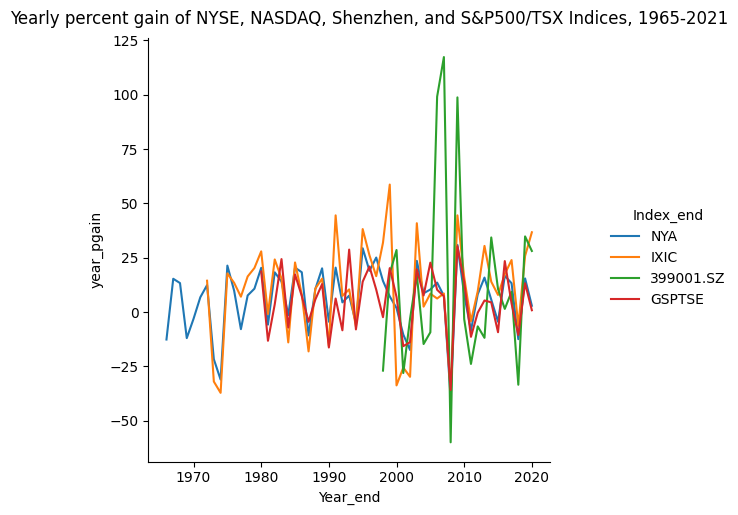

In [125]:
#Average percent gain every year 

g = sns.relplot(year.loc[year.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='year_pgain',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Yearly percent gain of NYSE, NASDAQ, Shenzhen, and S&P500/TSX Indices, 1965-2021', y=1.02)
# plt.title('Percent Gains per Index, 1965 - 2021\n buy/sell 1st week 4th week')




In [ ]:
#cumulative gain every year 

g = sns.relplot(year.loc[year.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='year_pgain',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Yearly percent gain of NYSE, NASDAQ, Shenzhen, and S&P500/TSX Indices, 1965-2021', y=1.02)
# plt.title('Percent Gains per Index, 1965 - 2021\n buy/sell 1st week 4th week')




Text(0.5, 28.999999999999986, 'Year')

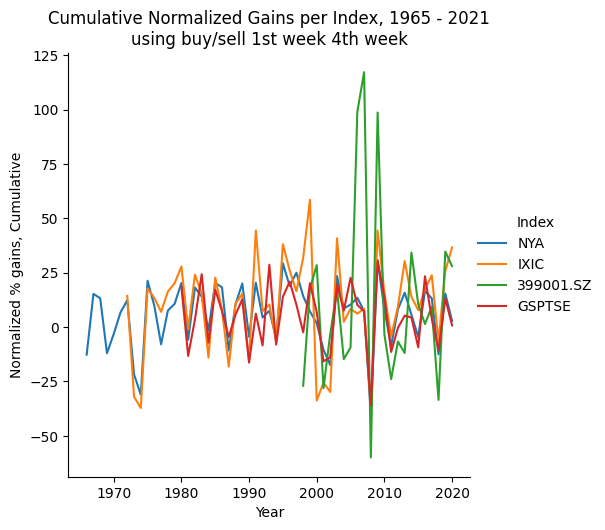

In [124]:
#using normal investing 

g = sns.relplot(year_sum_gains.loc[year_sum_gains.Index.str.contains('NYA|IXIC|SZ|GSP')], 
                x='Year_end_mean', y='year_pgain_sum', 
                kind='line', 
                hue='Index',
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
               )
# plt.arrow(2000, 150, 15, -30, width=0.75)
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
plt.title('Cumulative Normalized Gains per Index, 1965 - 2021\nusing buy/sell 1st week 4th week')
plt.ylabel('Normalized % gains, Cumulative')
plt.xlabel('Year')

Text(0.5, 28.999999999999986, 'Year')

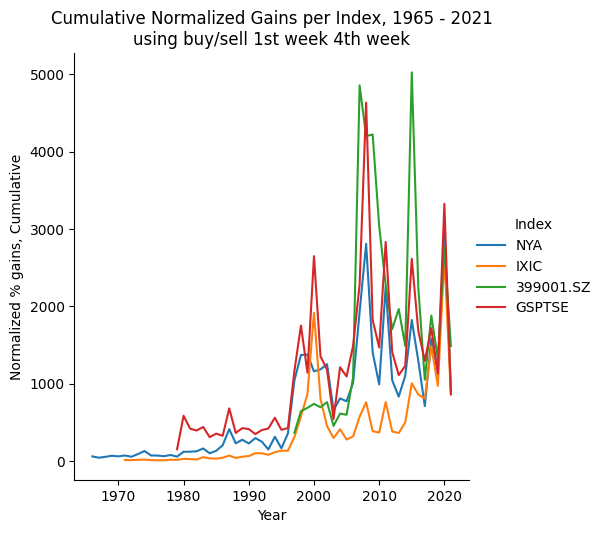

In [100]:
#using buy/sell strategy

g = sns.relplot(buysell_12month.loc[buysell_12month.Index.str.contains('NYA|IXIC|SZ|GSP')], 
                x='Year_end_mean', y='buylowsellhigh_pgain_sum', 
                kind='line', 
                hue='Index',
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
               )
# plt.arrow(2000, 150, 15, -30, width=0.75)
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
plt.title('Cumulative Normalized Gains per Index, 1965 - 2021\nusing buy/sell 1st week 4th week')
plt.ylabel('Normalized % gains, Cumulative')
plt.xlabel('Year')

Text(0.5, 28.999999999999986, 'Year')

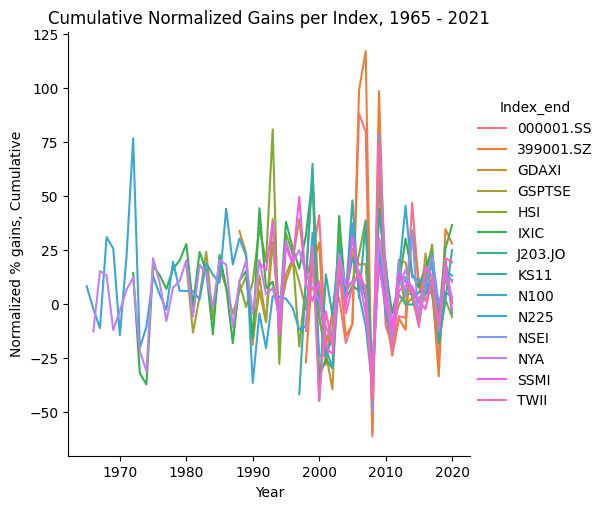

In [28]:
g = sns.relplot(year, x='Year_end', y='year_pgain', kind='line', hue='Index_end')
# plt.arrow(2000, 150, 15, -30, width=0.75)
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
plt.title('Cumulative Normalized Gains per Index, 1965 - 2021')
plt.ylabel('Normalized % gains, Cumulative')
plt.xlabel('Year')

Text(-2, -18, 'Why are years with a lot of positive events\n showing negative yearly percent returns? ')

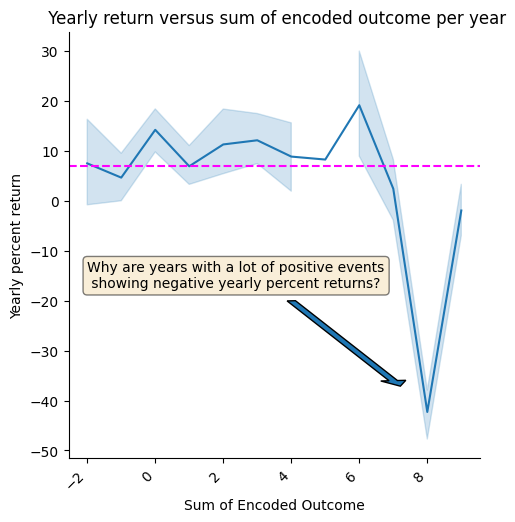

In [30]:
stocks_and_events_df = year.merge(events_by_year, how='left', left_on = 'Year_end', right_on = 'Year')

sns.relplot(stocks_and_events_df, 
             x='eOutcome_sum',
             y='year_pgain',
             # size = 'Outcome_count',
             sizes=(10, 100),
             kind='line'
             # hue = 'eOutcome_median',
             # palette=['red','orangered','gold','yellowgreen','green']
           )
plt.xticks(rotation=45, ha='right')
plt.axhline(y=7, color='magenta', ls='--')
plt.xlabel('Sum of Encoded Outcome')
plt.ylabel('Yearly percent return')
plt.title(' Yearly return versus sum of encoded outcome per year')
plt.arrow(4,-20,3,-16, width=0.25)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-2, -18, 'Why are years with a lot of positive events\n showing negative yearly percent returns? ', fontsize=10,
        verticalalignment='bottom', bbox=props)

In [247]:
stocks_and_events_df.loc[stocks_and_events_df.eOutcome_sum > 7].Year.unique()

array([2008, 2010, 2018, 1975], dtype=int32)

In [39]:
cat_year_count = stocks_and_events_df[['Year','category','Outcome']].groupby('Year').agg(['count'])
stocks_year_count = stocks_and_events_df.select_dtypes(include='number').groupby('Year').agg(['mean','median','std', 'sum'])
stocks_and_events_groupby_year_df = cat_year_count.merge(stocks_year_count, how = 'left',left_on = 'Year', right_on = 'Year')

stocks_and_events_groupby_year_df.columns = ['_'.join(col).strip() for col in stocks_and_events_groupby_year_df.columns.values]
stocks_and_events_groupby_year_df.columns = stocks_and_events_groupby_year_df.columns.to_flat_index()
stocks_and_events_groupby_year_df.reset_index(inplace=True)

KeyError: "['category', 'Outcome'] not in index"

In [40]:
len(stocks_and_events_groupby_year_df.shape)

NameError: name 'stocks_and_events_groupby_year_df' is not defined

In [133]:
for col in stocks_and_events_groupby_year_df.columns:
    print(col)

Year
category_count
Outcome_count
Adj Close_mean_mean
Adj Close_mean_median
Adj Close_mean_std
Adj Close_mean_sum
Adj Close_median_mean
Adj Close_median_median
Adj Close_median_std
Adj Close_median_sum
Adj Close_std_mean
Adj Close_std_median
Adj Close_std_std
Adj Close_std_sum
Adj Close_sum_mean
Adj Close_sum_median
Adj Close_sum_std
Adj Close_sum_sum
Close_mean_mean
Close_mean_median
Close_mean_std
Close_mean_sum
Close_median_mean
Close_median_median
Close_median_std
Close_median_sum
Close_std_mean
Close_std_median
Close_std_std
Close_std_sum
Close_sum_mean
Close_sum_median
Close_sum_std
Close_sum_sum
Daily_Return_mean_mean
Daily_Return_mean_median
Daily_Return_mean_std
Daily_Return_mean_sum
Daily_Return_median_mean
Daily_Return_median_median
Daily_Return_median_std
Daily_Return_median_sum
Daily_Return_std_mean
Daily_Return_std_median
Daily_Return_std_std
Daily_Return_std_sum
Daily_Return_sum_mean
Daily_Return_sum_median
Daily_Return_sum_std
Daily_Return_sum_sum
High_mean_mean
High_me

In [ ]:
stocks_and_events_groupby_year_df['pos_neg'] = stocks_and_events_groupby_year_df.apply()

Text(0.5, 1.0, 'Overall outcome per year versus Yearly return, size by number of events')

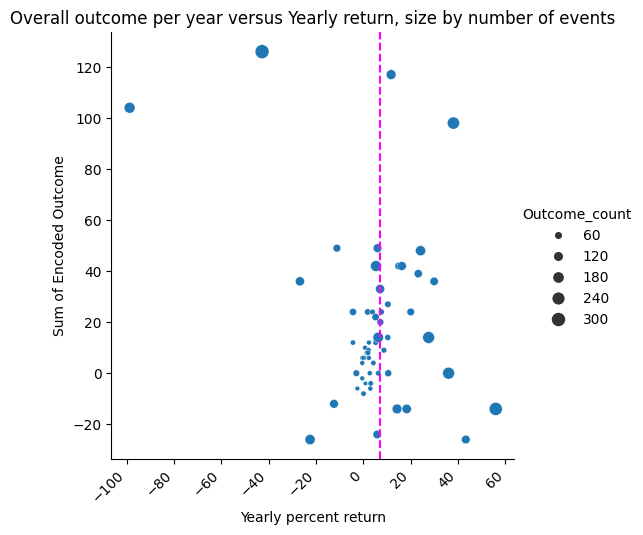

In [178]:
sns.relplot(stocks_and_events_groupby_year_df, 
             x='Daily_Return_sum_sum',
             y='eOutcome_sum',
             size = 'Outcome_count',
             sizes=(10, 100)
             # hue = 'eOutcome_median',
             # palette=['red','orangered','gold','yellowgreen','green']
           )
plt.xticks(rotation=45, ha='right')
plt.axvline(x=7, color='magenta', ls='--')
plt.xlabel('Yearly percent return')
plt.ylabel('Sum of Encoded Outcome')
plt.title('Overall outcome per year versus Yearly return, size by number of events')

In [622]:
# To properly join events with data_combined dataframe we'll need to create a data column to join on
# Step A: evaluate the Year, Month, & Date to see iaf anything needs cleaned before joining

We can see that Day values have several non-day, missing, and unknown values that need to be cleaned before merging with the rest of the columns.
We also see that there are months that are showing as NANs as well, without the exact month dropping instead of assigning Jan or July would probably be safest.

Since there are multiple events per date so a simple join on date wouldn't work well so we will take the following steps:
1. Create an event map of about 10 event groups
2. Map the groups to df_events['Type of Event']
3. Combine the events on the same date into one row
4. Encode the grouped events into indicator features for clustering and modelling

Now that the dates are down to one row and encoded we'll join the event_df with the combined_df

Numeric vs. Categorical Analysis

Price variables all move together (corr ≈ 1.0), so they’re redundant. Volume barely correlates with price (≈ 0.14). To get more insight, we need to examine distribution patterns by index or create additional features like daily returns or volatility.

In [22]:
stocks_and_events_groupby_year_df.columns

Index(['Year', 'category_count', 'Outcome_count', 'Adj Close_mean_mean',
       'Adj Close_mean_median', 'Adj Close_mean_std', 'Adj Close_mean_sum',
       'Adj Close_median_mean', 'Adj Close_median_median',
       'Adj Close_median_std',
       ...
       'p_gain_sum_std', 'p_gain_sum_sum', 'Sl. No_mean', 'Sl. No_median',
       'Sl. No_std', 'Sl. No_sum', 'eOutcome_mean', 'eOutcome_median',
       'eOutcome_std', 'eOutcome_sum'],
      dtype='object', length=123)

Rolling averages and short–term volatility measures also correlate strongly with the underlying Close price, so only one from each group is needed. The most unique signals come from Intraday Volatility, Range, and Volume Change, which show lower correlation and therefore capture different market behavior.

Core engineered features

- Daily_Return

- Volatility_5D OR Volatility_10D (not both)

- Rolling_Avg_Close_7D OR Rolling_Avg_Close_30D

- Volume_Change

- Range

- Intraday_Volatility

One price anchor

- Close (drop Open, High, Low)

One volume anchor

- Volume (keeping the raw value)


---



Do a crosstab of Region and Currency categorical features

In [648]:
pd.crosstab(df_data_index["Region"], df_data_index["Currency"])

Currency,CAD,CHF,CNY,EUR,HKD,INR,JPY,KRW,TWD,USD,ZAR
Region,,,,,,,,,,,
Canada,10796,0,0,0,0,0,0,0,0,0,0
China,0,0,11917,0,0,0,0,0,0,0,0
Europe,0,0,0,5519,0,0,0,0,0,0,0
Germany,0,0,0,8625,0,0,0,0,0,0,0
Hong Kong,0,0,0,0,8769,0,0,0,0,0,0
India,0,0,0,0,0,3393,0,0,0,0,0
Japan,0,0,0,0,0,0,14526,0,0,0,0
Korea,0,0,0,0,0,0,0,6196,0,0,0
South Africa,0,0,0,0,0,0,0,0,0,0,2394


Create Clusters

In [649]:
# engineered features to aggregate
eng_features = [
    'Daily_Return', 'Volatility_5D', 'Volatility_10D',
    'Rolling_Avg_Close_50D', 'Rolling_Avg_Close_200D',
    'Volume_Change', 'Range', 'Intraday_Volatility'
]

# Replace infinities with NaN since this will interfere with clustring
df_data_index.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all rows with NaNs???
df_num = df_data_index[['Index'] + eng_features].dropna()


# filter only numeric features (dropping NaNs from rolling windows)
df_num = df_data_index[['Index'] + eng_features].dropna()

# compute mean values per Index
df_index_features = df_num.groupby("Index")[eng_features].mean().reset_index()

df_index_features


,Index,Daily_Return,Volatility_5D,Volatility_10D,Rolling_Avg_Close_50D,Rolling_Avg_Close_200D,Volume_Change,Range,Intraday_Volatility
0,000001.SS,0.000333,0.012182,0.012735,2757.151804,2808.270381,0.019121,46.148129,0.016830
1,399001.SZ,0.000463,0.015718,0.016412,10092.490193,10100.860357,5.293841,219.977018,0.021614
2,GDAXI,0.000450,0.011973,0.012420,8540.652300,8320.640451,0.090783,128.299496,0.016034
3,GSPTSE,0.000234,0.008494,0.008816,13692.898088,13539.042850,1.519601,149.027249,0.011526
4,HSI,0.000306,0.011944,0.012406,23232.167131,22814.496287,0.040384,316.921460,0.013374
5,IXIC,0.000532,0.010813,0.011261,2643.025236,2539.486708,0.018415,38.645399,0.013380
6,KS11,0.000419,0.008664,0.009034,2023.227025,1961.738467,0.069908,21.828750,0.010678
7,N100,0.000169,0.010465,0.010896,851.208859,844.566865,0.075606,10.489247,0.013068
8,N225,0.000544,0.012677,0.013279,15692.391879,15252.082698,0.019794,196.669976,0.012773
9,NSEI,0.000945,0.007259,0.007813,9670.745037,9232.328571,0.065113,97.043965,0.009819


In [318]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(stocks_and_events_groupby_year_df[['eOutcome_median']])
# [col for col in stocks_and_events_groupby_year_df.columns if "p_" in col]

In [319]:
from sklearn.cluster import KMeans
# Came back after the elbow curve and changed clusters to 6
#kmeans = KMeans(n_clusters=3, random_state=42)
kmeans = KMeans(n_clusters=3, random_state=42)
stocks_and_events_groupby_year_df['Cluster'] = kmeans.fit_predict(X_scaled)

stocks_and_events_groupby_year_df


,Year,category_count,Outcome_count,Adj Close_mean_mean,Adj Close_mean_median,Adj Close_mean_std,Adj Close_mean_sum,Adj Close_median_mean,Adj Close_median_median,Adj Close_median_std,...,p_gain_sum_sum,Sl. No_mean,Sl. No_median,Sl. No_std,Sl. No_sum,eOutcome_mean,eOutcome_median,eOutcome_std,eOutcome_sum,Cluster
0,1965,10,10,865.074898,865.074898,354.580814,8.650749e+03,865.615021,865.615021,355.150153,...,0.000000,713.400000,732.0,188.518906,7134,1.000000,1.0,0.000000,10,0
1,1966,10,10,983.618783,983.618783,522.839750,9.836188e+03,980.622513,980.622513,517.061397,...,0.000000,645.600000,878.0,406.689945,6456,-0.200000,-1.0,1.032796,-2,1
2,1967,10,10,974.518116,974.518116,461.015850,9.745181e+03,989.612488,989.612488,472.873807,...,0.000000,614.400000,529.0,384.124170,6144,0.600000,1.0,0.843274,6,0
3,1968,14,14,1065.323239,1065.323239,500.157716,1.491453e+04,1065.779984,1065.779984,500.309160,...,0.000000,692.428571,837.0,305.708185,9694,0.000000,0.0,0.784465,0,2
4,1969,14,14,1267.988705,1267.988705,716.501691,1.775184e+04,1251.390015,1251.390015,698.742387,...,0.000000,646.285714,683.0,265.823374,9048,0.571429,1.0,0.755929,8,0
5,1970,6,6,1337.535004,1337.535004,936.045606,8.025210e+03,1311.720032,1311.720032,906.305591,...,0.000000,440.333333,497.0,114.306022,2642,1.000000,1.0,0.000000,6,0
6,1971,15,15,1024.662458,573.535732,1020.713169,1.536994e+04,1029.546646,578.809998,1023.611308,...,0.000000,358.600000,90.0,393.589852,5379,-0.400000,0.0,0.507093,-6,2
7,1972,27,27,1508.287844,637.195339,1635.659966,4.072377e+04,1491.043355,634.739990,1611.938205,...,0.000000,344.555556,194.0,268.811964,9303,0.333333,1.0,0.832050,9,0
8,1973,18,18,1824.903831,607.136906,2144.062723,3.284827e+04,1803.975077,607.089996,2115.016828,...,0.000000,519.833333,392.5,266.252037,9357,0.666667,1.0,0.485071,12,0
9,1974,9,9,1605.731974,463.140475,2011.016274,1.445159e+04,1663.409950,470.739990,2093.126877,...,0.000000,518.000000,536.0,416.776919,4662,-0.666667,-1.0,0.500000,-6,1


In [320]:
cluster_profiles = stocks_and_events_groupby_year_df.groupby("Cluster").describe()
cluster_profiles

Year                                                            \
        count         mean        std     min      25%     50%      75%   
Cluster                                                                   
0        34.0  1990.558824  15.759925  1965.0  1977.25  1989.5  2004.25   
1         7.0  1991.857143  19.945163  1966.0  1979.00  1985.0  2006.50   
2        16.0  1998.687500  16.563891  1968.0  1990.75  2000.5  2012.75   

                category_count              ... eOutcome_std            \
            max          count        mean  ...          75%       max   
Cluster                                     ...                          
0        2020.0           34.0   73.764706  ...     0.870184  1.005249   
1        2021.0            7.0   54.714286  ...     0.959860  1.032796   
2        2019.0           16.0  100.937500  ...     0.878529  1.021508   

        eOutcome_sum                                                         
               count       mean        std   min    25%   50%    75%    max  
Cluster                                                                      
0               34.0  31.970588  32.692771   4.0   9.25  23.0  41.25  126.0  
1                7.0 -12.000000   9.660918 -26.0 -19.00  -8.0  -5.00   -2.0  
2               16.0   2.562500  17.888427 -26.0  -7.50   0.0   6.50   42.0  

[3 rows x 984 columns]

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to

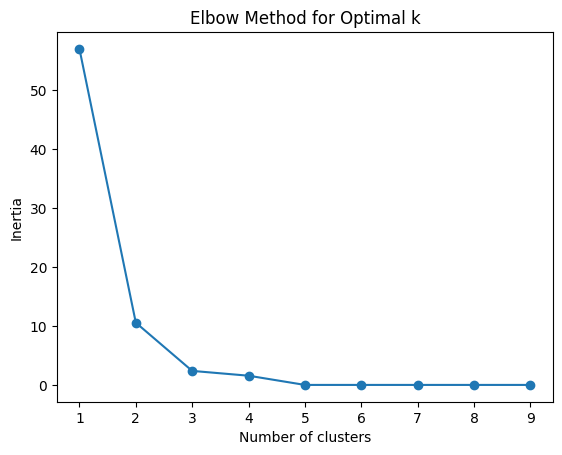

In [321]:
from sklearn.cluster import KMeans
inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)


plt.plot(range(1,10), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()


We see that after 5-6 there's stops being a significant change in inertia (How far points are from their assigned cluster centers.) So we'll select k=6.

Next we'll visualize the boxplot of the clusters.

<Axes: xlabel='p_gain_sum_mean', ylabel='eOutcome_sum'>

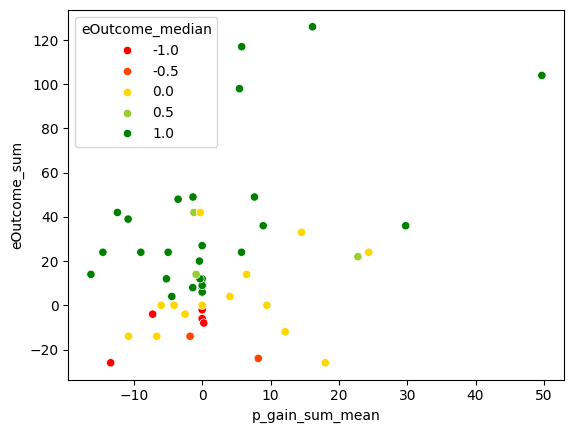

In [322]:
sns.scatterplot(stocks_and_events_groupby_year_df, 
             x='p_gain_sum_mean',
             y='eOutcome_sum',
             hue = 'eOutcome_median',
             palette=['red','orangered','gold','yellowgreen','green']
           )

#interesting to see positive years have a very large spread vs mixed and negative years? 

<Axes: xlabel='p_gain_sum_mean', ylabel='eOutcome_sum'>

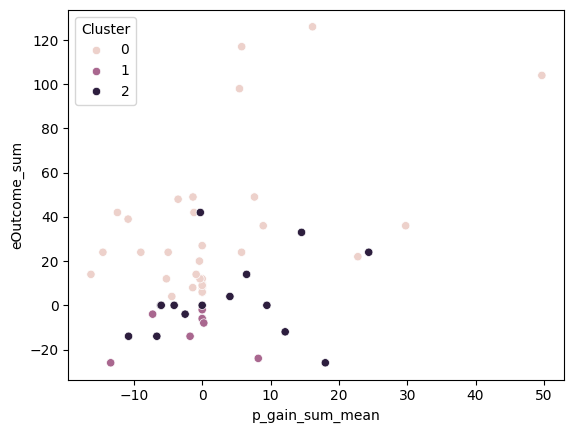

In [324]:
#KMeans cluster looks kind of useless here... 
sns.scatterplot(stocks_and_events_groupby_year_df, 
             x='p_gain_sum_mean',
             y='eOutcome_sum',
             hue = 'Cluster',
             # palette=['orange','blue','gold']
            
           )

<Axes: xlabel='Cluster', ylabel='eOutcome_sum'>

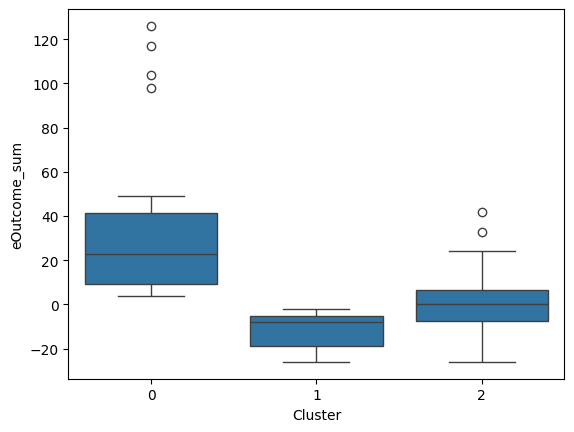

In [325]:
sns.boxplot(stocks_and_events_groupby_year_df, 
             x='Cluster',
             y='eOutcome_sum',
           )

In [287]:
stocks_and_events_groupby_year_df.columns.unique()

Index(['Year', 'category_count', 'Outcome_count', 'Adj Close_mean_mean',
       'Adj Close_mean_median', 'Adj Close_mean_std', 'Adj Close_mean_sum',
       'Adj Close_median_mean', 'Adj Close_median_median',
       'Adj Close_median_std',
       ...
       'p_gain_sum_sum', 'Sl. No_mean', 'Sl. No_median', 'Sl. No_std',
       'Sl. No_sum', 'eOutcome_mean', 'eOutcome_median', 'eOutcome_std',
       'eOutcome_sum', 'Cluster'],
      dtype='object', length=124)

In [301]:
stocks_and_events_groupby_year_df['eOutcome_median'].unique()

array([ 1. , -1. ,  0. ,  0.5, -0.5])

In [317]:
gain_cols = [col for col in stocks_and_events_groupby_year_df.columns if "p_" in col]
X_train, X_test, y_train, y_test = train_test_split(stocks_and_events_groupby_year_df[gain_cols], 
                                                    stocks_and_events_groupby_year_df[['eOutcome_median']], test_size=.2) #5 median values is easier to classify 

le = LabelEncoder()
y_train = le.fit_transform(y_train)
# model = LinearRegression()
# model = LogisticRegression()
model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, objective='multi:softprob')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
r_squared = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print(f'r2:{r_squared}\nmse: {mse}')
#Linear regression gives r2:-6744762.45712806, mse: 1967222.674995684Not good 
#logistic model gives r2:-6.428571428571429, mse: 4.333333333333333. Better but also bad
#XGB model gives r2:-7.943396226415096, mse: 3.2916666666666665. Slightly worse but also bad 



C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2:-17.196363636363643
mse: 8.6875


## Step 3:  Identify 1-3 research questions and perform analysis

Now that you have a better understanding of the data, you will want to form a research question which is interesting to you. The research question should be broad enough to be of interest to a reader but narrow enough that the question can be answered with the data.  Some examples:

* __Too Narrow:__  What is the GDP of the U.S. for 2011?  This is just asking for a fact or a single data point.  

* __Too Broad:__  What is the primary reason for global poverty?  This could be a Ph.D. thesis and would still be way too broad.  What data will you use to answer this question?  Even if a single dataset offered an answer, would it be defendable given the variety of datasets out there?

* __Good:__  Can you use simple sentiment analysis on comments about movies in a movie database to predict its box office earnings?  If you have, or can obtain, data on a variety of movies and you have their box office earnings, this is a question which you can potentially answer well.

__Remember__, this course is for learning Python. You will not be graded on the complexity, accuracy or performance of your analytical methods. However, you are expected to use a Python library, e.g., _scikitlearn_, successfully to generate results and explain why you picked the methods you used.



In [657]:
#OVERVIEW YOUR QUESTION AND PERFORM YOUR ANALYSIS IN THIS SECTION

## Step 4:  Present your findings

In this step, you can begin to report your findings.  What did you learn from the data and how do your findings help answer your research question?  Use _matplotlib_ visualizations to present these findings.


__Remember:__ Rarely will a single data analysis conclusively answer a research question.  Here, you need to identify possible limitations.  For example, are your results limited to a certain area, city, or country?  Are you making assumptions about the data which may, or may not, be valid (e.g., that students in one term are equally qualified as students in another)?  Document these limitations in a few paragraphs.


In [658]:
#EXPAND THIS SECTION TO PRESENT YOUR FINDINGS